# Unconstrained Numerical Optimization

This notebook introduces numerical optimization for a function $f : \mathbb{R}^2 \to \mathbb{R}$ known as the Rosenbrock function, which is very commonly used in optimization: 
$$ f(x,y) =(y - x^2)^2 + 0.5 (1-x)^2, \quad x \in [-2; 2], y\in [-6; 4]. $$

**Note:** You must have a folder, `img`, in the present directory. 

In [1]:
import numpy as np 
from scipy.optimize import minimize 
import matplotlib.pyplot as plt 

In [2]:
np.finfo(float).eps

2.220446049250313e-16

In [3]:
10 + np.finfo(float).eps - 10

0.0

In [4]:
# Numerical derivative 
def d(func, x0, h=1.49e-08):
    P = x0.size 
        
    # Take a forward step
    if x0 != 0:
        x1 = x0 * (1 + h)
    
    # If 0, then we need to take absolute step
    else:
        x1 = h

    step = x1 - x0
    grad = (func(x1) - func(x0))/step
    return grad

In [5]:
def rosen(x): 
    return .5*(1 - x[0])**2 + (x[1] - x[0]**2)**2

def rosen_grad(x): 
    ''' returns the vector of 2 partial derivatives '''
    return np.array((-2*.5*(1 - x[0]) - 4*x[0]*(x[1] - x[0]**2), 2*(x[1] - x[0]**2)))

def rosen_hess(x):
    ''' returns the 2*2 matrix of second derivatives '''
    return np.array(((1 - 4*x[1] + 12*x[0]**2, -4*x[0]), (-4*x[0], 2)))

Compute the Rosenbrock function over a grid 

In [6]:
N = 10 # grid points in each dimension
x = np.linspace(-2, 2, N)
y = np.linspace(-6, 4, N)

X, Y = np.meshgrid(x, y)
Z = np.empty(X.shape)
for i1 in range(N):
    for i2 in range(N): 
        x_ = X[i1,i2]
        y_ = Y[i1,i2]
        Z[i1,i2] = rosen([x_, y_])

The simplest way of plotting

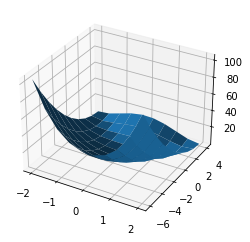

In [7]:
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z);

And now let's make it a little nicer.

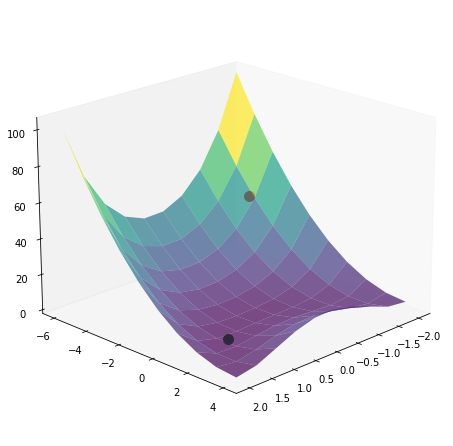

In [8]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(X,Y,Z,
                cmap='viridis', alpha=0.7)
ax.plot(1,1,rosen([1,1])*1.01, 'o', color='green', markersize=10) #the global minimum 
ax.plot(-1.5,-4,rosen([-1.5,-4])*1.01, 'o', color='red', markersize=10) # our starting values throughout
ax.view_init(elev=20, azim=45) # rotate the plot by 45 degrees for visibility 
ax.grid(b=None) # remove grid lines 
fig.subplots_adjust(top=1.1, bottom=-.1, left=-0.1, right=1.5) # enlarge plot
plt.savefig('img/rosen.pdf', bbox_inches='tight')

For future use and simplifying the code, let's write a function to draw this that we can plot on top of. 

In [9]:
def draw_rosen():
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111,projection='3d')
    ax.plot_surface(X,Y,Z,cmap='viridis', alpha=0.7)
    ax.view_init(elev=20, azim=45)
    ax.grid(b=None)
    fig.subplots_adjust(top=1.1, bottom=-.1, left=-0.1, right=1.5) # enlarge plot
    return fig,ax

## Show together with approximating quadratic

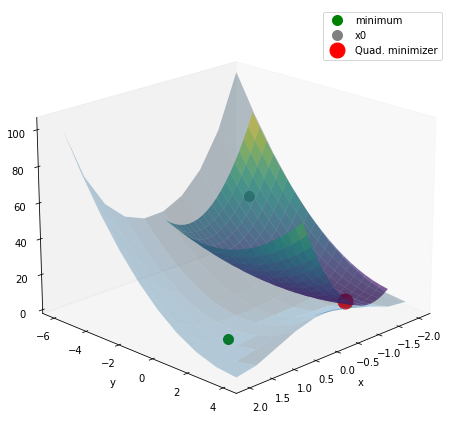

In [10]:
x0 = np.array([-1.5, -4])

# evaluate the (fixed) components for the approximation 
f0 = rosen(x0)
g0 = rosen_grad(x0)
h0 = rosen_hess(x0)

def quad_app(x):
    diff = x - x0
    return f0 + g0@diff + .5 * diff@h0@diff

quad_min = x0 - np.linalg.solve(h0,g0)

N_ = 20
h = 1
xx_ = np.linspace(x0[0]-h, x0[0]+h, N_)
yy_ = np.linspace(x0[1]-h, x0[1]+h, N_)
xx_ = np.linspace(-2, 0.1, N_)
yy_ = np.linspace(-5, 3, N_)
X_, Y_ = np.meshgrid(xx_,yy_)

Z_app = np.empty(X_.shape)
for i1 in range(X_.shape[0]): 
    for i2 in range(X_.shape[1]):
        t = np.array([X_[i1,i2], Y_[i1,i2]])
        Z_app[i1, i2] = quad_app(t)
        
# truncate above
# zmax = Z.max()
# Z_app[Z_app > zmax] = np.nan

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(X,Y,Z, alpha=0.3)

ax.plot_surface(X_,Y_,Z_app,
                cmap='viridis', alpha=0.7)

ax.plot(1,1,rosen([1,1])*1.01, 'o', color='green', markersize=10) #the global minimum 
ax.plot(-1.5,-4,rosen([-1.5,-4])*1.01, 'o', color='gray', markersize=10) # our starting values throughout
ax.plot(quad_min[0], quad_min[1], 1.01*quad_app(quad_min), 'o', color='r', markersize=15)

# ax.set_zlim((Z.min(), Z.max()))
ax.view_init(elev=20, azim=45) # rotate the plot by 45 degrees for visibility 
ax.grid(b=None) # remove grid lines 
ax.set_xlabel('x'); ax.set_ylabel('y');
fig.subplots_adjust(top=1.1, bottom=-.1, left=-0.1, right=1.5) # enlarge plot
ax.legend(['minimum','x0', 'Quad. minimizer'])
plt.savefig('img/rosen_with_quad.pdf', bbox_inches='tight')

# Own minimizer

Minimal code 

In [11]:
def my_min(x0, tol, maxit): 
    '''unconstrained minimizer, simple version'''
    # keep track of where the optimizer has been (for plotting)
    x_list = [x0]
    f_list = [rosen(x0)]
    
    x = x0
    
    norm = np.max(np.abs(rosen_grad(x)))
    print(f'it=0, x=({x[0]:8.4f}, {x[1]:8.4f}), norm={norm:10.4g} f(x)={rosen(x):10.4g}')
    
    for it in range(1,maxit):
        
        g = rosen_grad(x)
        h = rosen_hess(x)
        step = np.linalg.solve(h,g)
        x = x - step 

        # storing the trial values 
        x_list.append(x)
        f_list.append(rosen(x))
        
        # check convergence
        norm = np.max(np.abs(rosen_grad(x)))
        print(f'{it=}, x=({x[0]:8.4f}, {x[1]:8.4f}), norm={norm:10.4g} f(x)={rosen(x):10.4g}')
        if norm < tol:
            print(f'Convergence achieved!')
            break
    
    x_list = np.array(x_list)
    return x, x_list, f_list

In [12]:
rosen_grad([-1.4, 1.9615])

array([-2.3916,  0.003 ])

In [13]:
x, x_list, f_list = my_min(x0, 1e-8, 100)

it=0, x=( -1.5000,  -4.0000), norm=        40 f(x)=     42.19
it=1, x=( -1.4038,   1.9615), norm=     2.456 f(x)=     2.889
it=2, x=(  0.9143,  -4.5378), norm=     19.57 f(x)=     28.88
it=3, x=(  0.9181,   0.8429), norm=   0.08186 f(x)=  0.003355
it=4, x=(  1.0000,   0.9933), norm=   0.02683 f(x)= 4.502e-05
it=5, x=(  1.0000,   1.0000), norm= 1.243e-07 f(x)= 7.736e-15
it=6, x=(  1.0000,   1.0000), norm= 6.217e-14 f(x)= 2.416e-28
Convergence achieved!


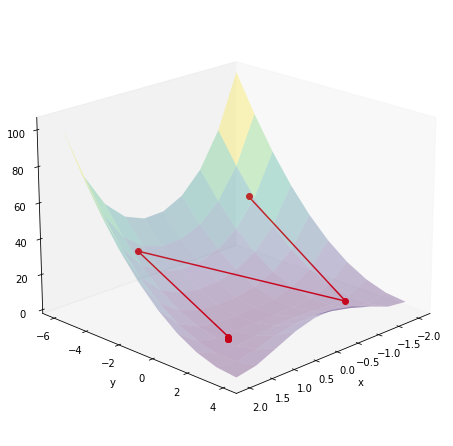

In [14]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(X,Y,Z,alpha=0.3,cmap='viridis')
ax.plot(x_list[:,0], x_list[:,1], f_list, '-or')

ax.view_init(elev=20, azim=45) # rotate the plot by 45 degrees for visibility 
ax.grid(b=None) # remove grid lines 
ax.set_xlabel('x'); ax.set_ylabel('y');
fig.subplots_adjust(top=1.1, bottom=-.1, left=-0.1, right=1.5) # enlarge plot

plt.savefig('img/path_vanilla_newton.pdf', bbox_inches='tight')

# Using Scipy's `minimize`

In [15]:
xx = np.array([])
yy = np.array([])
ff = np.array([])
Nit = 0

def callbackF(Xi, DOPRINT):
    global xx, yy, ff, Nit
    f = rosen(Xi)
    
    if DOPRINT: 
        if Nit == 0: #print header 
            print(f'Iter.:      x0       x1     f(x)')
                
        print(f'{Nit:4d}: {Xi[0]:8.4f} {Xi[1]:8.4f} {f:8.4g}')
    
    # append current state to global list 
    xx = np.append(xx, Xi[0])
    yy = np.append(yy, Xi[1])
    ff = np.append(ff, f)
    Nit += 1

def call_print(Xi):
    callbackF(Xi, DOPRINT=True)

def call_noprint(Xi):
    callbackF(Xi, DOPRINT=False)
    
# convenient
def reset():
    global xx, yy, ff, Nit
    xx = np.array([])
    yy = np.array([])
    ff = np.array([])
    Nit = 0

In [16]:
x0 = np.array([-1.5, -4.])

In [17]:
res = minimize(rosen, x0, method='BFGS')
print(res)

      fun: 4.541329226303777e-12
 hess_inv: array([[0.99867628, 1.98941293],
       [1.98941293, 4.45531332]])
      jac: array([-1.97090810e-06, -4.63469706e-07])
  message: 'Optimization terminated successfully.'
     nfev: 57
      nit: 16
     njev: 19
   status: 0
  success: True
        x: array([0.99999701, 0.99999377])


In [18]:
res = minimize(rosen, x0, method='Nelder-Mead')
print(res)

 final_simplex: (array([[1.00000183, 1.00001693],
       [0.99998151, 0.99995121],
       [1.00004695, 1.00007481]]), array([1.77484872e-10, 3.10372661e-10, 1.46620912e-09]))
           fun: 1.7748487192891172e-10
       message: 'Optimization terminated successfully.'
          nfev: 93
           nit: 49
        status: 0
       success: True
             x: array([1.00000183, 1.00001693])


Iter.:      x0       x1     f(x)
   0:  -1.5000  -4.0000    42.19
   1:  -0.5360  -3.6987    17.07
   2:   0.4756  -2.8988    9.903
   3:   0.2685  -0.7629   0.9648
   4:   0.1931  -0.0012    0.327
   5:   0.6986   0.2979  0.08157
   6:   0.8901   0.9274  0.02427
   7:   1.0342   1.1421 0.005849
   8:   1.0570   1.1296 0.001778
   9:   1.0523   1.1049 0.001373
  10:   1.0151   1.0467 0.0003799
  11:   0.9950   0.9949 3.586e-05
  12:   0.9972   0.9940 4.072e-06
  13:   0.9991   0.9971 1.813e-06
  14:   1.0000   1.0000 4.18e-12
     fun: 4.17980089181358e-12
     jac: array([ 5.47526802e-06, -1.32314734e-06])
 message: 'Optimization terminated successfully.'
    nfev: 78
     nit: 14
    njev: 26
  status: 0
 success: True
       x: array([1.00000273, 1.0000048 ])


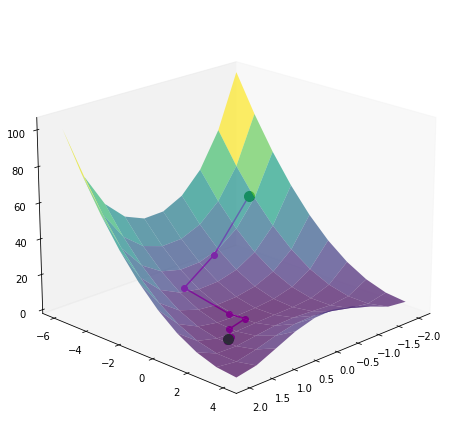

In [19]:
reset()

call_print(x0)
res = minimize(rosen, x0, method='CG', callback=call_print)
print(res)

fig,ax = draw_rosen();
ax.plot(xx, yy, ff, '-o', color='magenta');
ax.plot(x0[0], x0[1], rosen(x0), 'o', color='green', markersize=10); # starting value
ax.plot(1,1,rosen([1,1]), 'og', markersize=10); # the global minimum

plt.savefig('img/path_CG.pdf', bbox_inches='tight')

# Comparing different methods

In [20]:
res

     fun: 4.17980089181358e-12
     jac: array([ 5.47526802e-06, -1.32314734e-06])
 message: 'Optimization terminated successfully.'
    nfev: 78
     nit: 14
    njev: 26
  status: 0
 success: True
       x: array([1.00000273, 1.0000048 ])

In [21]:
def min_and_plot(method, **kwargs):
    reset()

    call_noprint(x0) # connect initial value to sequence
    res = minimize(rosen, x0, method=method, callback=call_noprint, **kwargs)
    print(f'{method:<8}: {res["nfev"]} fct. evaluations, x={res["x"]}')

    fig,ax = draw_rosen();
    ax.plot(xx, yy, ff, '-o', color='magenta');
    ax.plot(x0[0], x0[1], rosen(x0), 'o', color='green', markersize=10); # starting value
    ax.plot(1,1,rosen([1,1]), 'og', markersize=10); # the global minimum

CG      : 78 fct. evaluations, x=[1.00000273 1.0000048 ]


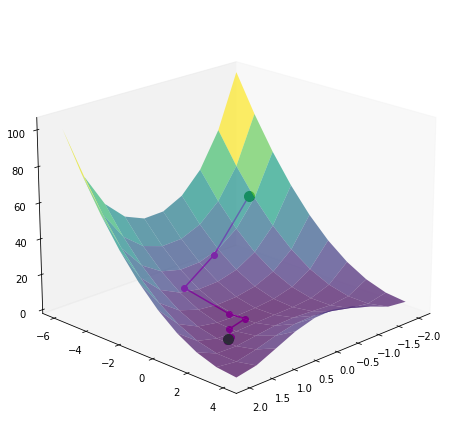

In [22]:
min_and_plot('CG')

Newton-CG: 12 fct. evaluations, x=[1. 1.]


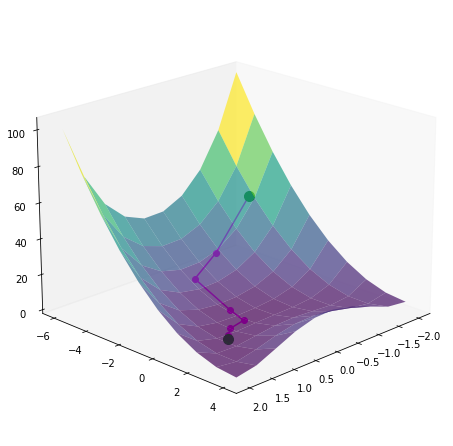

In [23]:
min_and_plot('Newton-CG', jac=rosen_grad, hess=rosen_hess)

BFGS    : 57 fct. evaluations, x=[0.99999701 0.99999377]


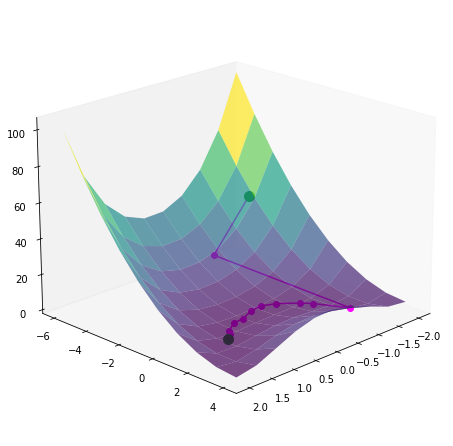

In [24]:
min_and_plot('BFGS')
plt.savefig('img/path_bfgs.pdf', bbox_inches='tight')

Nelder-Mead: 93 fct. evaluations, x=[1.00000183 1.00001693]


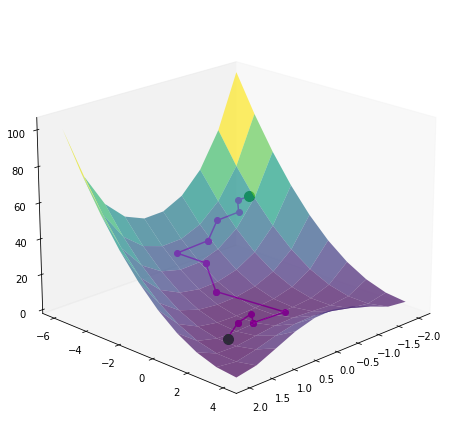

In [25]:
min_and_plot('Nelder-Mead')
plt.savefig('img/path_nelder_mead.pdf', bbox_inches='tight')

Powell  : 196 fct. evaluations, x=[1. 1.]


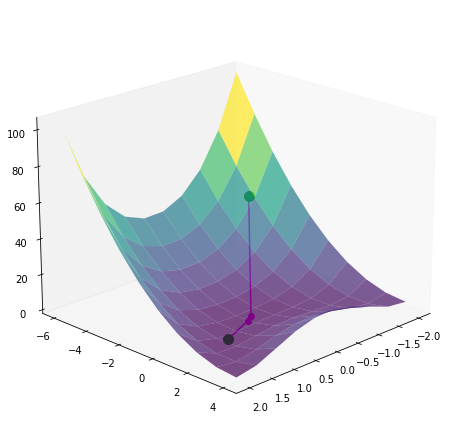

In [26]:
min_and_plot('Powell')
plt.savefig('img/path_powell.pdf', bbox_inches='tight')

# Nelder-Mead

 final_simplex: (array([[1.00000183, 1.00001693],
       [0.99998151, 0.99995121],
       [1.00004695, 1.00007481]]), array([1.77484872e-10, 3.10372661e-10, 1.46620912e-09]))
           fun: 1.7748487192891172e-10
       message: 'Optimization terminated successfully.'
          nfev: 93
           nit: 49
        status: 0
       success: True
             x: array([1.00000183, 1.00001693])


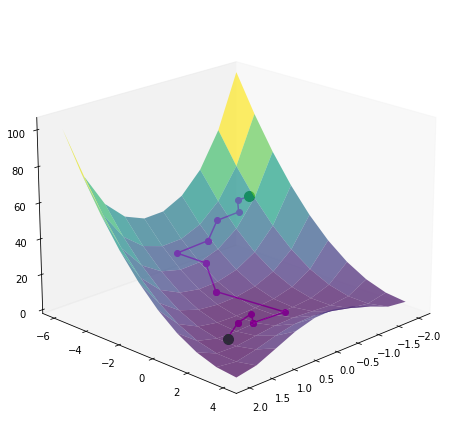

In [27]:
reset()

call_noprint(x0) # add initial value to list 
res = minimize(rosen, x0, method='Nelder-Mead', callback=call_noprint)
print(res)

fig,ax = draw_rosen()
ax.plot(xx, yy, ff, '-o', color='magenta'); # show the iteration values 
ax.plot(x0[0], x0[1], rosen(x0), 'o', color='green', markersize=10); #show starting values 
ax.plot(1,1,rosen([1,1]), 'og', markersize=10); # show global minimum

# Powell's Method

   direc: array([[ 1.03784685e+00,  1.46237445e+00],
       [-1.95469149e-04, -5.63856415e-04]])
     fun: 1.67632942359465e-30
 message: 'Optimization terminated successfully.'
    nfev: 196
     nit: 7
  status: 0
 success: True
       x: array([1., 1.])


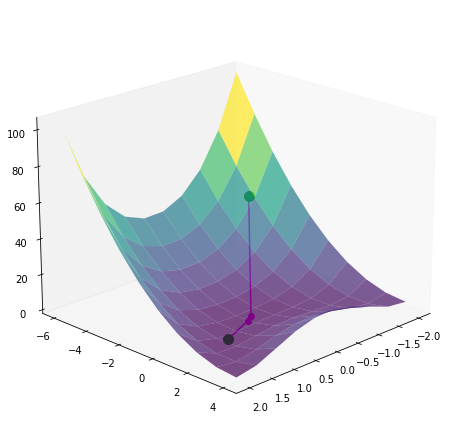

In [28]:
reset()

call_noprint(x0) # add initial value to list 
res = minimize(rosen, x0, method='Powell', callback=call_noprint)
print(res)

fig,ax = draw_rosen()
ax.plot(xx, yy, ff, '-o', color='magenta'); # show the iteration values 
ax.plot(x0[0], x0[1], rosen(x0), 'o', color='green', markersize=10); #show starting values 
ax.plot(1,1,rosen([1,1]), 'og', markersize=10); # show global minimum

# Analytical gradient 

Note that the number of iterations is unchanged, only the number of function evaluations changes (since we are not taking so many numerical derivative steps in the algorithm). 

In [29]:
res = minimize(rosen, x0, method='BFGS', jac=None)
print(res)

      fun: 4.541329226303777e-12
 hess_inv: array([[0.99867628, 1.98941293],
       [1.98941293, 4.45531332]])
      jac: array([-1.97090810e-06, -4.63469706e-07])
  message: 'Optimization terminated successfully.'
     nfev: 57
      nit: 16
     njev: 19
   status: 0
  success: True
        x: array([0.99999701, 0.99999377])


In [30]:
res = minimize(rosen, x0, method='BFGS', jac=rosen_grad)
print(res)

      fun: 4.252451069459415e-12
 hess_inv: array([[0.99867643, 1.9894134 ],
       [1.9894134 , 4.45531459]])
      jac: array([-1.97089761e-06, -4.63474371e-07])
  message: 'Optimization terminated successfully.'
     nfev: 19
      nit: 16
     njev: 19
   status: 0
  success: True
        x: array([0.9999971 , 0.99999397])


In [31]:
res = minimize(rosen, x0, method='Newton-CG', jac=rosen_grad, hess=rosen_hess)
print(res)

     fun: 3.303462000907271e-23
     jac: array([ 2.18340643e-06, -1.96641647e-06])
 message: 'Optimization terminated successfully.'
    nfev: 12
    nhev: 10
     nit: 10
    njev: 12
  status: 0
 success: True
       x: array([1., 1.])


     fun: 3.303462000907271e-23
     jac: array([ 2.18340643e-06, -1.96641647e-06])
 message: 'Optimization terminated successfully.'
    nfev: 12
    nhev: 10
     nit: 10
    njev: 12
  status: 0
 success: True
       x: array([1., 1.])


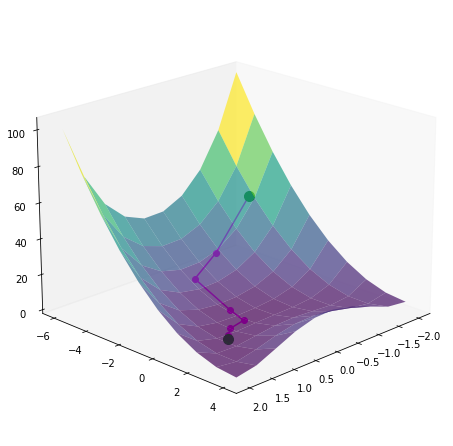

In [32]:
reset()

call_noprint(x0) # add initial value to list 
res = minimize(rosen, x0, method='Newton-CG', jac=rosen_grad, hess=rosen_hess, callback=call_noprint)
print(res)

fig,ax = draw_rosen()
ax.plot(xx, yy, ff, '-o', color='magenta'); # show the iteration values 
ax.plot(x0[0], x0[1], rosen(x0), 'o', color='green', markersize=10); #show starting values 
ax.plot(1,1,rosen([1,1]), 'og', markersize=10); # show global minimum

# Noisy Rosenbrock

Now, let us annoy our optimizer by adding a small amount of white noise to the criterion function 
$$ \tilde{f}(x) = f(x) + u, \quad u \sim N(0,0.0001). $$
The fact that the dispersion on the "measurement error", $u$, is so small, implies that we cannot visually see the noise when we zoom out too far on our criterion function. However, when we zoom in a lot, it becomes visible. 

In [33]:
def rosen_noisy(x, sigma=1e-4):
    f = 100 * (x[1] - x[0]**2)**2 + (1.0 - x[0])**2 
    u = np.random.normal(0,sigma)
    return f+u

Iter.:      x0       x1     f(x)
   0:  -1.5000  -4.0000    42.19
   1:  -0.8426   2.2941    4.207
   2:  -2.0895   3.0021    6.633
   3:  -2.0895   3.0021    6.633
      fun: 195.6172635047403
 hess_inv: array([[5.63010939e-05, 5.85343554e-06],
       [5.85343554e-06, 6.08562047e-07]])
      jac: array([ 779.63725662, 2275.61746407])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 102
      nit: 3
     njev: 31
   status: 2
  success: False
        x: array([-2.0895456 ,  3.00211868])


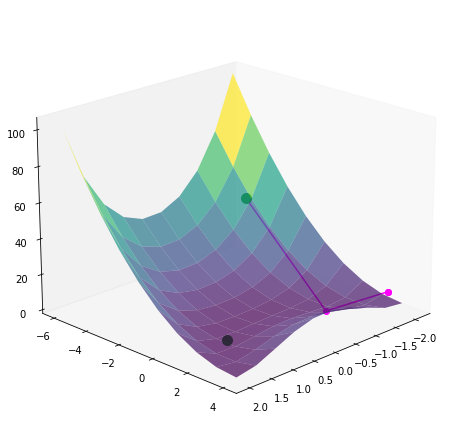

In [34]:
reset()

np.random.seed(2)
call_print(x0)
res = minimize(rosen_noisy, x0, method='BFGS', callback=call_print)

print(res)

fig,ax = draw_rosen()
ax.plot(xx, yy, ff, '-o', color='magenta'); # show the iteration values 
ax.plot(x0[0], x0[1], rosen(x0), 'o', color='green', markersize=10); #show starting values 
ax.plot(1,1,rosen([1,1]), 'og', markersize=10); # show global minimum

plt.savefig('img/noisy_bfgs_failure.pdf', bbox_inches='tight')

 final_simplex: (array([[0.99765371, 0.99550936],
       [0.99765377, 0.9955095 ],
       [0.99765373, 0.9955094 ]]), array([-0.00024118, -0.00019297, -0.00014375]))
           fun: -0.00024118190554698007
       message: 'Optimization terminated successfully.'
          nfev: 181
           nit: 86
        status: 0
       success: True
             x: array([0.99765371, 0.99550936])


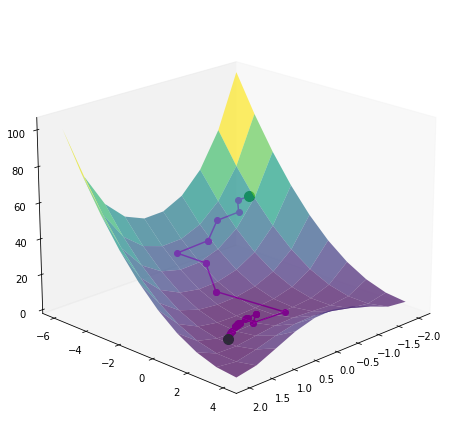

In [35]:
reset()

call_noprint(x0)
res = minimize(rosen_noisy, x0,method='Nelder-Mead', callback=call_noprint)
print(res)

fig,ax = draw_rosen()
ax.plot(xx, yy, ff, '-o', color='magenta'); # show the iteration values 
ax.plot(x0[0], x0[1], rosen(x0), 'o', color='green', markersize=10); #show starting values 
ax.plot(1,1,rosen([1,1]), 'og', markersize=10); # show global minimum

plt.savefig('img/noisy_nelder_mead_success.pdf', bbox_inches='tight')

## Nelder-Mead fails even with many iterations

In [36]:
res = minimize(rosen_noisy, x0, args=(1e-3), method='Nelder-Mead', callback=call_noprint, options={'maxiter':100000, 'maxfev':100000})
print(res)

 final_simplex: (array([[1.00962738, 1.01724252],
       [1.00962738, 1.01724252],
       [1.00962738, 1.01724252]]), array([-0.00342462,  0.00015704,  0.00100032]))
           fun: -0.003424617834327787
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 100000
           nit: 37752
        status: 1
       success: False
             x: array([1.00962738, 1.01724252])


## Saving BFGS with a smaller step size 

Our criterion function has noise in it. However, the noise level is very low. Hence, we can increase the step size used to compute the numerical gradients. This is done by setting the option, `eps`, to a larger value than the default, which is close to `1e-8`. For instance, we could use `1e-3`. This will naturally mean that we have more approximation error in our numerical gradients, but we get rid of more of the error due to the simulation draws. 

Iter.:      x0       x1     f(x)
   0:  -1.5000  -4.0000    42.19
   1:  -0.5418  -3.6808    16.98
   2:  -1.6622   3.4582    4.027
   3:  -1.7093   3.0116    3.678
   4:  -1.7134   2.9348    3.681
   5:  -1.6938   2.8754    3.628
   6:  -1.4553   2.0909    3.015
   7:  -1.3944   1.8970    2.869
   8:  -1.3690   1.8403    2.807
   9:  -1.2948   1.6565    2.634
  10:  -1.1058   1.1821    2.219
  11:  -1.0370   1.0194    2.078
  12:  -0.9926   0.9370    1.987
  13:  -0.8938   0.7545    1.795
  14:  -0.7854   0.6116    1.594
  15:  -0.6826   0.4350    1.417
  16:  -0.5852   0.2929    1.259
  17:  -0.5164   0.2238    1.152
  18:  -0.4437   0.1872    1.042
  19:  -0.3248   0.0722   0.8786
  20:  -0.2421   0.0158   0.7733
  21:  -0.1873   0.0054   0.7058
  22:  -0.0652  -0.0147   0.5677
  23:   0.0483  -0.0152   0.4531
  24:   0.2251   0.0262   0.3009
  25:   0.2587   0.0763   0.2749
  26:   0.4016   0.1337   0.1798
  27:   0.3892   0.1429   0.1866
  28:   0.4745   0.2110   0.1383
  29:   0.

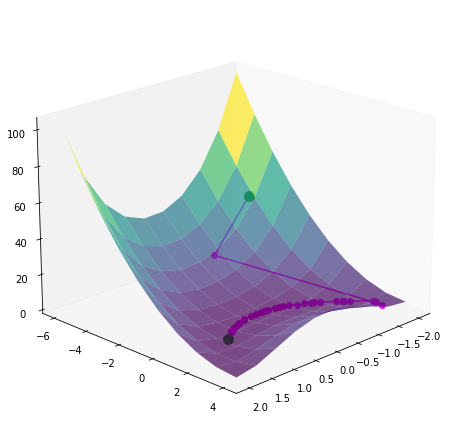

In [37]:
reset()

np.random.seed(2)
call_print(x0)
res = minimize(rosen_noisy, x0, method='BFGS', callback=call_print, options={'eps':1e-3})

print(res)

fig,ax = draw_rosen()
ax.plot(xx, yy, ff, '-o', color='magenta'); # show the iteration values 
ax.plot(x0[0], x0[1], rosen(x0), 'o', color='green', markersize=10); #show starting values 
ax.plot(1,1,rosen([1,1]), 'og', markersize=10); # show global minimum